El objetivo de este notebook es crear un recomendador muy sencillo, que sirva de línea base y con el que poder comparar

In [1]:
from typing import Dict, List, Tuple, Union, Any, Optional

import os
import sys
print("Python version", sys.version)

import numpy as np
import pandas as pd
import itertools as it

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.autonotebook import tqdm

from src.datasets import daocensus_text, to_microsoft
from src.model_selection import timeIntervalSplit, timeFreqSplitCurrent
from src.utils import notebooks as nbutils

sns.set_theme()

Python version 3.9.18 (main, Oct 24 2023, 09:18:18) 
[GCC 11.4.0]


/tmp/ipykernel_462416/804985562.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# Dataset splits config
N_SPLITS: int = 10

# Always 0, just skip the first rows in the CSV to compare with others
SKIP_SPLIT: int = 0

# the second way of making splits
SPLITS_FREQ: str = 'W-THU'
SPLITS_NORMALIZE: bool = True
LAST_SPLITS: int = 10 # Only used to generate baseline graph

K_RECOMMENDATIONS: List[int] = [5, 10, 15]

ORG_NAME: str = 'Decentraland'
ORG_PLATFORM: str = 'snapshot'
USE_ORG_NAMES: bool = True

CUTOFF_DATE_STR = ... # Not used

In [3]:
# Parameters
ORG_NAME = "Aave - Aavegotchi"
ORG_PLATFORM = "snapshot"
SPLITS_FREQ = "5d"
SPLITS_NORMALIZE = True
LAST_SPLITS = 10
USE_ORG_NAMES = True
EXECUTION_ID = "2024-03-21"
CUTOFF_DATE_STR = "2023-07-29"


# Load data

In [4]:
# dfv, dfp = daocensus.get("./data/daos-census", ORG_NAME, 'snapshot')
# dfptime = pd.read_csv('./snapshot_proposals.csv')[['proposal_id', 'title', 'description', 'start', 'end']]
# dfp = dfp.merge(dfptime, how='left', left_on='platform_proposal', right_on='proposal_id')
# dfp[['start', 'end']] = dfp[['start', 'end']].astype('datetime64')

dfv, dfp = daocensus_text.get("./data/daos-census-text", ORG_NAME, ORG_PLATFORM, use_org_names=USE_ORG_NAMES)
print(dfv.info())
print(dfp.info())

Warning, removing 2326043 votes without proposal


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2326043 entries, 0 to 2326042
Data columns (total 10 columns):
 #   Column         Dtype         
---  ------         -----         
 0   platform       object        
 1   name           object        
 2   id             object        
 3   proposal       category      
 4   deployment     object        
 5   platform_vote  object        
 6   voter          category      
 7   date           datetime64[ns]
 8   choice         object        
 9   weight         float64       
dtypes: category(2), datetime64[ns](1), float64(1), object(6)
memory usage: 173.6+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 719 entries, 0 to 718
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   platform             719 non-null    object        
 1   name                 719 non-null    object        
 2   platform_deployment  719 non-null    o

In [5]:
df = to_microsoft(dfv)
df.head()

,userID,itemID,timestamp,rating
0,0x9080196182f77b89bb5b0eee3ddb48cfa716c4c3,cf9a3163-c94e-54c2-a5e8-0c8181c0a05c,2021-08-20 04:58:39,1
1,0x4cd3210ce0e7aef75ecff5475b75034dc328b1d4,cf9a3163-c94e-54c2-a5e8-0c8181c0a05c,2021-08-20 02:26:10,1
2,0x9b93b3de14160d9ca56512e49f6d94cc761c1612,cf9a3163-c94e-54c2-a5e8-0c8181c0a05c,2021-08-19 23:42:35,1
3,0x303f68639795a93778a205b8c050bd1d1136cb95,cf9a3163-c94e-54c2-a5e8-0c8181c0a05c,2021-08-19 22:39:01,1
4,0x6519e6117480d140cd7d33163ac30fd01812f34a,cf9a3163-c94e-54c2-a5e8-0c8181c0a05c,2021-08-19 19:04:03,1


# Exploring data

## How much time does each proposal take

Most proposals take a week, but there are a few that take less than 7 days.

count                          719
mean     6 days 22:24:20.979137691
std      6 days 16:46:19.739860807
min                1 days 00:00:00
25%                3 days 00:00:00
50%                5 days 12:50:09
75%                7 days 00:00:00
max               80 days 00:00:00
dtype: object

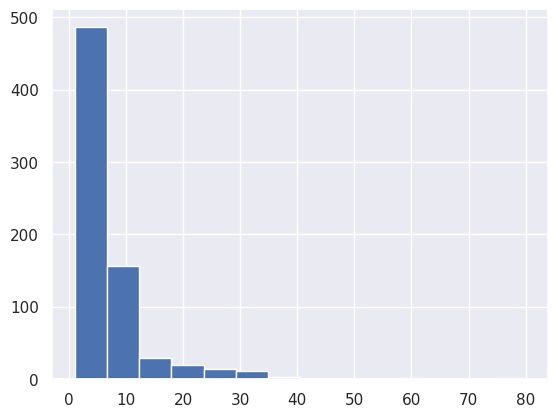

In [6]:
delta = dfp['end'] - dfp['start']
delta.dt.days.hist(bins=14)
delta.describe()

In [7]:
delta.value_counts()

3 days 00:00:00    157
7 days 00:00:00     78
5 days 00:00:00     33
4 days 00:00:00     28
6 days 00:00:00     19
                  ... 
6 days 00:01:00      1
6 days 21:29:22      1
6 days 23:59:05      1
5 days 23:59:45      1
5 days 12:00:00      1
Length: 318, dtype: int64

### Just for MetaCartel, avg proposal length in time

<Axes: xlabel='date'>

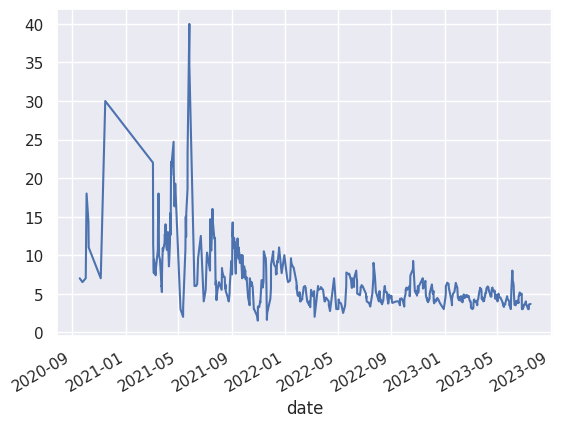

In [8]:
# TODO
_delta = dfp.assign(delta=delta).set_index('date').sort_index()['delta'].dt.days
_delta.rolling('7D').mean().plot()

## What day or the week are proposals created

Tuesday      141
Wednesday    131
Thursday     117
Monday       113
Friday        90
Saturday      68
Sunday        59
Name: start, dtype: int64

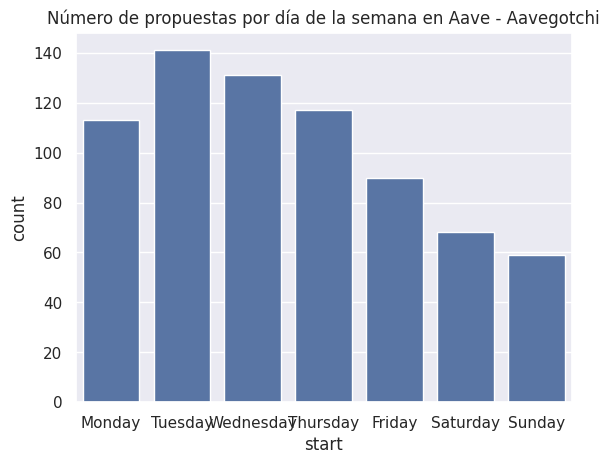

In [9]:
import seaborn as sns

ax = sns.countplot(x=dfp['start'].dt.day_name(), order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
ax.set_title(f'Número de propuestas por día de la semana en {ORG_NAME}')
dfp['start'].dt.day_name().value_counts()

Text(0, 0.5, '')

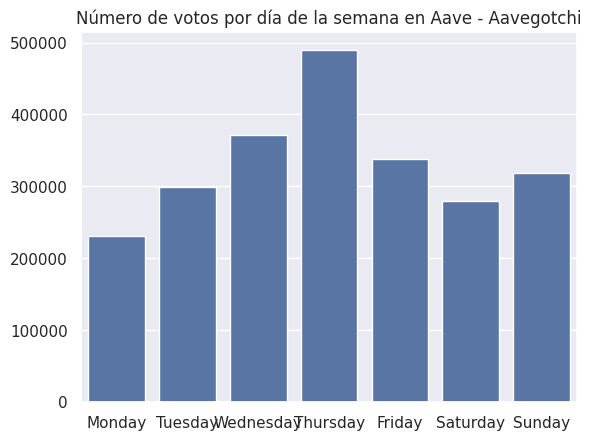

In [10]:
ax = sns.countplot(x=dfv['date'].dt.day_name(), order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
ax.set_title(f'Número de votos por día de la semana en {ORG_NAME}')
dfv['date'].dt.day_name().value_counts()
plt.xlabel('')
plt.ylabel('')

## Ahora en porcentaje acumulado

<Axes: xlabel='rel_day', ylabel='proposals'>

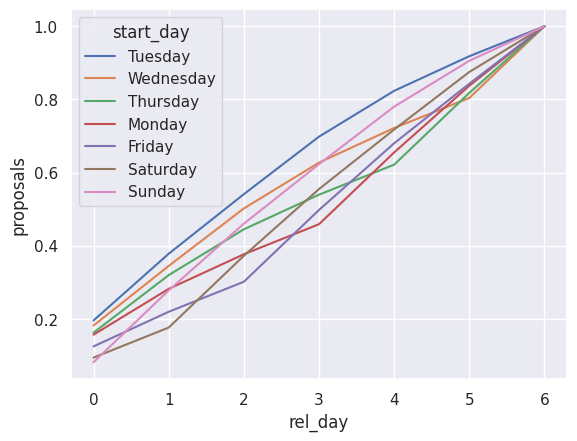

In [11]:
# ax = sns.countplot(x=dfp['start'].dt.day_name(), order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
# ax.set_title(f'Número de propuestas por día de la semana en {ORG_NAME}')
# dfp['start'].dt.day_name().value_counts()

start_from = 2

vc = dfp['start'].dt.day_name().value_counts()
vc = vc / vc.sum()
series = []
for i, d in enumerate(vc.index):
    newindex = vc.index[i:].union(vc.index[:i], sort=False)
    assert len(newindex) == 7
    assert newindex[0] == d
    
    s = vc.reindex(newindex) \
        .cumsum() \
        .to_frame(name='proposals') \
        .reset_index().rename(columns={'index': 'day'}) \
        .reset_index().rename(columns={'index': 'rel_day'})
    s['start_day'] = d
    series.append(s)

sns.lineplot(pd.concat(series), x='rel_day', y='proposals', hue='start_day')

### Same with votes

<Axes: xlabel='rel_day', ylabel='votes'>

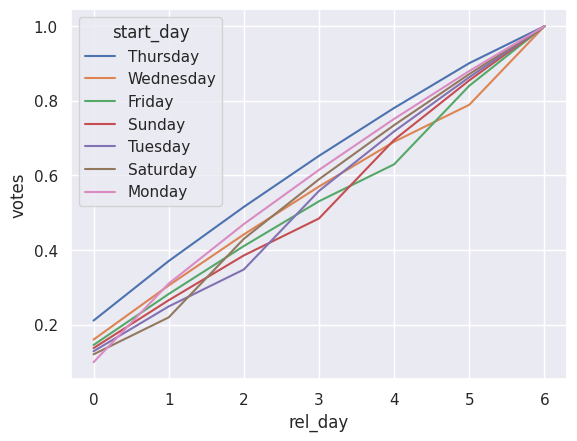

In [12]:
# ax = sns.countplot(x=dfp['start'].dt.day_name(), order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
# ax.set_title(f'Número de propuestas por día de la semana en {ORG_NAME}')
# dfp['start'].dt.day_name().value_counts()

start_from = 2

vc = dfv['date'].dt.day_name().value_counts()
vc = vc / vc.sum()
series = []
for i, d in enumerate(vc.index):
    newindex = vc.index[i:].union(vc.index[:i], sort=False)
    assert len(newindex) == 7
    assert newindex[0] == d
    
    s = vc.reindex(newindex) \
        .cumsum() \
        .to_frame(name='votes') \
        .reset_index().rename(columns={'index': 'day'}) \
        .reset_index().rename(columns={'index': 'rel_day'})
    s['start_day'] = d
    series.append(s)

sns.lineplot(pd.concat(series), x='rel_day', y='votes', hue='start_day')

## How many proposals are created per week

As we can see, there are peaks of over 70 proposals created in a week, using a recommendator can help the users know which proposals to chose.

<Axes: xlabel='start'>

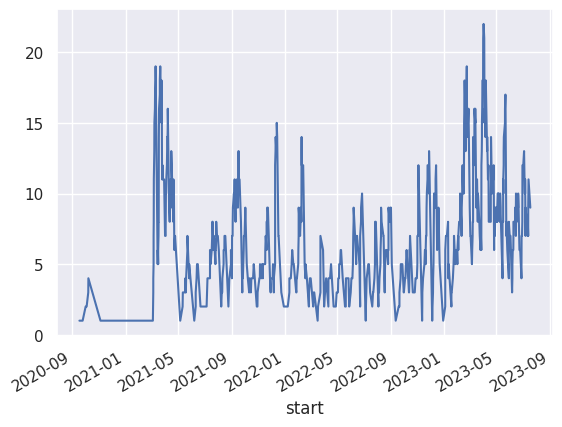

In [13]:
dfp.set_index('start').sort_index().rolling('7d')['id'].count().plot()

## VPP in test per recommendator

In [14]:
freqs = ['W-SUN', 'W-MON', 'W-TUE', 'W-WED', 'W-THU', 'W-SAT']
freq = freqs[0]

results = []
for freq in tqdm(freqs, leave=False):
    for dftrain, dftest, t, openproposals in timeFreqSplitCurrent(to_microsoft(dfv), freq, dfp.reset_index(), return_open=True, remove_not_in_train_col='userID'):
        dftrain_filter = dftrain[dftrain['itemID'].isin(openproposals)]
        
        results.append({
            'f': freq,
            't': t,
            # 'proposals in train': dftrain['itemID'].nunique(),
            # 'votes in train': len(dftrain),
            'votes in open proposals (train)': len(dftrain_filter),
            'users in open proposals (train)': dftrain_filter['userID'].nunique(),
            'open proposals': len(openproposals),
            'votes in test': len(dftest),
            'users in test': dftest['userID'].nunique(),
        })

res = pd.DataFrame(results)
res['vpp test'] = res['votes in test'] / res['open proposals']
res['vpu test'] = res['votes in test'] / res['users in test']
res.groupby('f').describe(percentiles=[]).T[freqs]

  0%|          | 0/6 [00:00<?, ?it/s]

f                                              W-SUN          W-MON  \
votes in open proposals (train) count     147.000000     147.000000   
                                mean     7154.469388    7299.401361   
                                std     14444.615807   17492.246050   
                                min         0.000000       0.000000   
                                50%      2356.000000    1975.000000   
                                max    104335.000000  144460.000000   
users in open proposals (train) count     147.000000     147.000000   
                                mean     2980.285714    2911.054422   
                                std      4449.328407    4738.846526   
                                min         0.000000       0.000000   
                                50%      1381.000000    1126.000000   
                                max     22178.000000   22680.000000   
open proposals                  count     147.000000     147.000000   
                                mean        4.761905       4.469388   
                                std         4.280144       4.407817   
                                min         0.000000       0.000000   
                                50%         4.000000       3.000000   
                                max        20.000000      21.000000   
votes in test                   count     147.000000     147.000000   
                                mean     3145.081633    2017.020408   
                                std      7516.007103    3149.417020   
                                min         0.000000       0.000000   
                                50%      1047.000000     844.000000   
                                max     57764.000000   17515.000000   
users in test                   count     147.000000     147.000000   
                                mean     1623.850340    1282.326531   
                                std      3044.092481    2122.143554   
                                min         0.000000       0.000000   
                                50%       563.000000     512.000000   
                                max     17333.000000   13176.000000   
vpp test                        count     129.000000     129.000000   
                                mean      643.033004     528.521324   
                                std      1071.205070     790.269076   
                                min         0.000000       0.000000   
                                50%       277.500000     248.333333   
                                max      7220.500000    5317.666667   
vpu test                        count     123.000000     122.000000   
                                mean        1.758926       1.650158   
                                std         0.807539       0.789982   
                                min         1.000000       1.000000   
                                50%         1.542910       1.410411   
                                max         5.191392       4.730603   

f                                             W-TUE          W-WED  \
votes in open proposals (train) count    147.000000     147.000000   
                                mean    5752.435374    5828.727891   
                                std    12295.337671   12476.987299   
                                min        0.000000       0.000000   
                                50%     2041.000000    1981.000000   
                                max    99726.000000  119405.000000   
users in open proposals (train) count    147.000000     147.000000   
                                mean    2651.081633    2699.510204   
                                std     4127.897774    4282.460996   
                                min        0.000000       0.000000   
                                50%     1030.000000    1113.000000   
                                max    19176.000000   19962.000000   
open proposals                  coun

In [15]:
res.groupby('f').sum().T[freqs]

/tmp/ipykernel_462416/4276310820.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  res.groupby('f').sum().T[freqs]


f,W-SUN,W-MON,W-TUE,W-WED,W-THU,W-SAT
votes in open proposals (train),1.051707e+06,1.073012e+06,845608.000000,856823.000000,983987.000000,1.043370e+06
users in open proposals (train),4.381020e+05,4.279250e+05,389709.000000,396828.000000,423867.000000,4.230010e+05
open proposals,7.000000e+02,6.570000e+02,665.000000,713.000000,739.000000,7.150000e+02
votes in test,4.623270e+05,2.965020e+05,418637.000000,523110.000000,673928.000000,5.038420e+05
users in test,2.387060e+05,1.885020e+05,252487.000000,269959.000000,330012.000000,2.893000e+05
vpp test,8.295126e+04,6.817925e+04,82500.585066,110074.338785,113481.422641,1.005480e+05
vpu test,2.163479e+02,2.013192e+02,202.273986,220.870928,228.193751,2.184691e+02


# Defining the baseline recommendator

Our baseline RecSys will be just recommending the top most famous proposals at time $t$.

In [16]:
from src.baseline import getBaselineRecommendations

"""
def getBaselineRecommendations(train: pd.DataFrame, users, k: int = 5, remove_train=True):
    bestVotes = train['itemID'].value_counts()
    df = pd.DataFrame(it.product(users, bestVotes.index), columns=['userID', 'itemID'])

    if remove_train:
        df = filter_by(df, train, ['userID', 'itemID'])
        
    df = df.groupby('userID').head(k).reset_index(drop=True)

    df['prediction'] = True
    return df
"""

# getBaselineRecommendations(folds[0][0], folds[0][1]['userID'].unique(), 3)

"\ndef getBaselineRecommendations(train: pd.DataFrame, users, k: int = 5, remove_train=True):\n    bestVotes = train['itemID'].value_counts()\n    df = pd.DataFrame(it.product(users, bestVotes.index), columns=['userID', 'itemID'])\n\n    if remove_train:\n        df = filter_by(df, train, ['userID', 'itemID'])\n        \n    df = df.groupby('userID').head(k).reset_index(drop=True)\n\n    df['prediction'] = True\n    return df\n"

# Evaluating the baseline recommendator with `timeIntervalSplit`

In [17]:
from recommenders.evaluation.python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k

In [18]:
def check_train_recs(df, filter_by_df, filter_by_cols):
    return any(df.set_index(filter_by_cols).index.isin(
        filter_by_df.set_index(filter_by_cols).index
    ))

In [19]:
from collections import defaultdict

folds = list(timeIntervalSplit(df, N_SPLITS, skip=SKIP_SPLIT, remove_not_in_train_col='userID'))
metrics_f = { 'precision':precision_at_k, 'ndcg': ndcg_at_k, 'ndcg': ndcg_at_k, 'map': map_at_k, 'recall': recall_at_k, }
# metrics = {n+f'@{k}':[] for k,n in it.product(K_RECOMMENDATIONS, metrics_f.keys())}
# perfectmetrics = {n+f'@{k}':[] for k,n in it.product(K_RECOMMENDATIONS, metrics_f.keys())}
metrics = defaultdict(list)
perfectmetrics = defaultdict(list)

for i, (train, test) in enumerate(folds):
    t = train.timestamp.max()
    print(f"===== Training on fold {i} (t: {t})  =====")
    # print(f"Ratings train: {len(train)}, test: {len(test)}")

    open_proposals = dfp[(dfp['start'] < t) & (t < dfp['end']) ]['id'].unique()
    print(f"Currently open proposals: {len(open_proposals)}")

    train_filtered = train[train['itemID'].isin(open_proposals) ]
    test_filtered = test[test['itemID'].isin(open_proposals) ]
    print(f"Train votes in open proposals: {len(train_filtered):3}")
    print(f"Test votes in open proposals:  {len(test_filtered):3}")    

    # print('Tested score:')
    for k_recs in K_RECOMMENDATIONS:
        recs = getBaselineRecommendations(train, test_filtered['userID'].unique(), open_proposals, k_recs)
    
        if check_train_recs(recs, train_filtered, ['userID', 'itemID']):
            print("There are recommendations that were true in training")
            assert False
        
        for m, f in metrics_f.items():
            r = f(test_filtered, recs, k=k_recs)
            # print(f'  {m}@{k_recs}:'.ljust(15), f'{r:.3}')
            metrics[m+f'@{k_recs}'].append(r)
            
        # print('Perfect predictor score:')
        recs = test_filtered.copy()
        recs['prediction'] = True
        for m, f in metrics_f.items():
            r = f(test_filtered, recs, k=k_recs)
            # print(f'  {m}@{k_recs}:'.ljust(15), f'{r:.3}')
            perfectmetrics[m+f'@{k_recs}'].append(r)
    
    print()

===== Training on fold 0 (t: 2020-12-15 09:44:45)  =====
Currently open proposals: 1
Train votes in open proposals:  22
Test votes in open proposals:    0

===== Training on fold 1 (t: 2021-03-25 03:01:53)  =====
Currently open proposals: 18
Train votes in open proposals: 1732
Test votes in open proposals:  1299



===== Training on fold 2 (t: 2021-06-27 04:50:43)  =====
Currently open proposals: 4
Train votes in open proposals: 2051
Test votes in open proposals:  224



===== Training on fold 3 (t: 2021-09-29 11:28:19)  =====
Currently open proposals: 10
Train votes in open proposals: 5870
Test votes in open proposals:  1987



===== Training on fold 4 (t: 2022-01-01 15:38:27)  =====
Currently open proposals: 3
Train votes in open proposals: 2117
Test votes in open proposals:  1284



===== Training on fold 5 (t: 2022-04-05 19:46:44)  =====
Currently open proposals: 3
Train votes in open proposals: 14423
Test votes in open proposals:  7541



===== Training on fold 6 (t: 2022-07-08 23:56:36)  =====
Currently open proposals: 4
Train votes in open proposals: 5695
Test votes in open proposals:  1509



===== Training on fold 7 (t: 2022-10-11 04:02:46)  =====
Currently open proposals: 3
Train votes in open proposals: 5844
Test votes in open proposals:  168



===== Training on fold 8 (t: 2023-01-13 08:19:03)  =====
Currently open proposals: 3
Train votes in open proposals: 13785
Test votes in open proposals:  2815



===== Training on fold 9 (t: 2023-04-17 12:23:26)  =====
Currently open proposals: 4
Train votes in open proposals: 38671
Test votes in open proposals:  1528


In [20]:
# from src import paths

# Won't even save it because its not used
# pd.DataFrame(metrics).to_csv(paths.baseline_mp(ORG_NAME, N_SPLITS), index=False)

,precision@5,ndcg@5,map@5,recall@5,precision@10,ndcg@10,map@10,recall@10,precision@15,ndcg@15,map@15,recall@15,perfect precision@5,perfect precision@10
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.223973,0.634282,0.575296,0.770258,0.125829,0.657316,0.589217,0.838598,0.086553,0.659944,0.591566,0.845536,0.266018,0.138503
std,0.110985,0.338485,0.344013,0.383009,0.055297,0.315045,0.327105,0.352218,0.039770,0.311745,0.324074,0.342871,0.129613,0.075793
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.208070,0.368626,0.274324,0.555966,0.109196,0.510133,0.348299,1.000000,0.072798,0.510133,0.348299,1.000000,0.218393,0.109196
50%,0.227467,0.759400,0.677570,1.000000,0.126129,0.759400,0.677570,1.000000,0.084086,0.759400,0.677570,1.000000,0.252258,0.126129
75%,0.257956,0.896663,0.857775,1.000000,0.152596,0.896663,0.857775,1.000000,0.101731,0.896663,0.857775,1.000000,0.304813,0.152596
max,0.428085,0.957940,0.943214,1.000000,0.214043,0.957940,0.943214,1.000000,0.142695,0.957940,0.943214,1.000000,0.473488,0.290930


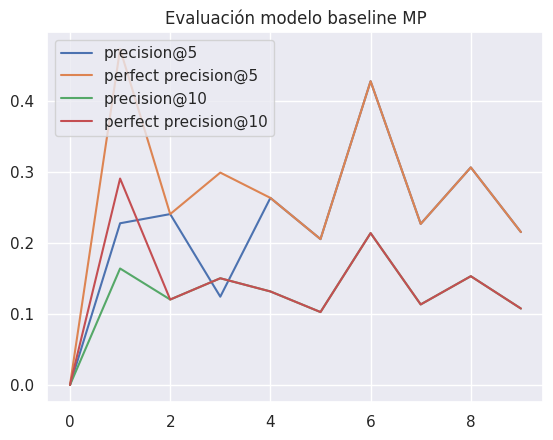

In [21]:
mdf = pd.DataFrame(metrics)
mdf['perfect precision@5'] = perfectmetrics['precision@5']
mdf['perfect precision@10'] = perfectmetrics['precision@10']
mdf[['precision@5', 'perfect precision@5', 'precision@10', 'perfect precision@10']].plot(title='Evaluación modelo baseline MP')
mdf.describe()

,precision@5,ndcg@5,map@5,recall@5,precision@10,ndcg@10,map@10,recall@10,precision@15,ndcg@15,map@15,recall@15
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.266018,0.900000,0.893517,0.893517,0.138503,0.900000,0.899189,0.899189,0.093064,0.900000,0.899985,0.899985
std,0.129613,0.316228,0.314586,0.314586,0.075793,0.316228,0.315953,0.315953,0.052182,0.316228,0.316223,0.316223
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.218393,1.000000,0.999196,0.999196,0.109196,1.000000,1.000000,1.000000,0.072798,1.000000,1.000000,1.000000
50%,0.252258,1.000000,1.000000,1.000000,0.126129,1.000000,1.000000,1.000000,0.084086,1.000000,1.000000,1.000000
75%,0.304813,1.000000,1.000000,1.000000,0.152596,1.000000,1.000000,1.000000,0.101731,1.000000,1.000000,1.000000
max,0.473488,1.000000,1.000000,1.000000,0.290930,1.000000,1.000000,1.000000,0.201240,1.000000,1.000000,1.000000


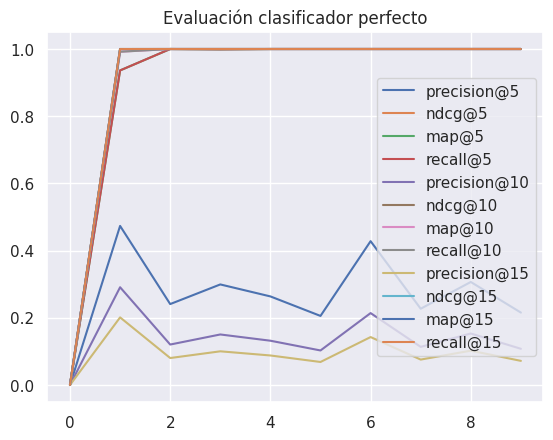

In [22]:
pmdf = pd.DataFrame(perfectmetrics)
pmdf.plot(title='Evaluación clasificador perfecto')
pmdf.describe()

# Evaluation the baseline recommendator with `timeFreqSplit`

In [23]:
from tqdm.autonotebook import tqdm

In [24]:
from functools import partial
import sys

folds = list(timeFreqSplitCurrent(df, SPLITS_FREQ, dfp, remove_not_in_train_col='userID', normalize=SPLITS_NORMALIZE))
metrics_f = { 'precision':precision_at_k, 'ndcg': ndcg_at_k, 'ndcg': ndcg_at_k, 'map': map_at_k, 'recall': recall_at_k, }
# metrics = {n+f'@{k}':[] for k,n in it.product(K_RECOMMENDATIONS, metrics_f.keys())}
metrics = defaultdict(list)
perfectmetrics = defaultdict(list)

for i, (train, test) in enumerate(tqdm(folds)):
    t = train.timestamp.max()

    assert not train.empty, f"Train should not be empty on fold {i}"
    # assert not test.empty, f"Test should not be empty on fold {i}"
    if test.empty:
        print(f"Warning, empty test fold {i}", file=sys.stderr)
    # print(f"===== Training on fold {i} (t: {t})  =====")
    # print(f"Ratings train: {len(train)}, test: {len(test)}")

    open_proposals = dfp[(dfp['start'] < t) & (t < dfp['end']) ]['id'].unique()
    # print(f"Currently open proposals: {len(open_proposals)}")

    train_filtered = train[train['itemID'].isin(open_proposals) ]
    test_filtered = test[test['itemID'].isin(open_proposals) ]
    # print(f"Train votes in open proposals: {len(train_filtered):3}")
    # print(f"Test votes in open proposals:  {len(test_filtered):3}")    

    # print('Tested score:')
    metrics['t'].append(t)
    perfectmetrics['t'].append(t)
    for k_recs in K_RECOMMENDATIONS:
        recs = getBaselineRecommendations(train, test_filtered['userID'].unique(), open_proposals, k_recs)
    
        if check_train_recs(recs, train_filtered, ['userID', 'itemID']):
            print("There are recommendations that were true in training")
            assert False

        for m, f in metrics_f.items():
            r = f(test_filtered, recs, k=k_recs)
            # print(f'  {m}@{k_recs}:'.ljust(15), f'{r:.3}')
            metrics[m+f'@{k_recs}'].append(r)
            
        # print('Perfect predictor score:')
        recs = test_filtered.copy()
        recs['prediction'] = True
        for m, f in metrics_f.items():
            r = f(test_filtered, recs, k=k_recs)
            # print(f'  {m}@{k_recs}:'.ljust(15), f'{r:.3}')
            perfectmetrics[m+f'@{k_recs}'].append(r)
    
    # print()

  0%|          | 0/206 [00:00<?, ?it/s]

Warning, empty test fold 0
Warning, empty test fold 1
Warning, empty test fold 2
Warning, empty test fold 4


Warning, empty test fold 5
Warning, empty test fold 6
Warning, empty test fold 7
Warning, empty test fold 8
Warning, empty test fold 9
Warning, empty test fold 10


Warning, empty test fold 16
Warning, empty test fold 17
Warning, empty test fold 18
Warning, empty test fold 19
Warning, empty test fold 20
Warning, empty test fold 21


Warning, empty test fold 22
Warning, empty test fold 23
Warning, empty test fold 24
Warning, empty test fold 25
Warning, empty test fold 26
Warning, empty test fold 27


Warning, empty test fold 28
Warning, empty test fold 29
Warning, empty test fold 30
Warning, empty test fold 31
Warning, empty test fold 32


Warning, empty test fold 80


Warning, empty test fold 108


Warning, empty test fold 130


Warning, empty test fold 133


Warning, empty test fold 145


Warning, empty test fold 156


Warning, empty test fold 165


Warning, empty test fold 193


In [25]:
print(df['timestamp'].min(), df['timestamp'].max())
_folds = list(timeFreqSplitCurrent(df, SPLITS_FREQ, dfp, remove_not_in_train_col='userID', normalize=SPLITS_NORMALIZE, inclusive='right', return_open=True))
_, _, t, _ = _folds[0]
print("t0:", t)
_, _, t, _ = _folds[1]
print("t1:", t)
_, _, t, _ = _folds[-2]
print("t-2:", t)
_, _, t, _ = _folds[-1]
print("t-1:", t)

2020-09-17 18:50:14 2023-07-20 16:39:36


t0: 2020-09-22 00:00:00
t1: 2020-09-27 00:00:00
t-2: 2023-07-09 00:00:00
t-1: 2023-07-14 00:00:00


In [26]:
{ k:len(v) for k,v in metrics.items() }

{'t': 206,
 'precision@5': 206,
 'ndcg@5': 206,
 'map@5': 206,
 'recall@5': 206,
 'precision@10': 206,
 'ndcg@10': 206,
 'map@10': 206,
 'recall@10': 206,
 'precision@15': 206,
 'ndcg@15': 206,
 'map@15': 206,
 'recall@15': 206}

In [27]:
display(dfp['date'].min())
display(df['timestamp'].min())
display(df.sort_values('timestamp').head())
display(dfp.sort_values('date').head())

Timestamp('2020-09-17 18:48:05')

Timestamp('2020-09-17 18:50:14')

,userID,itemID,timestamp,rating
532430,0x2c1ee1ec33c495989ca09ddd68df12cd17fa6f33,69493095-ceef-5f56-9224-aa1b377173be,2020-09-17 18:50:14,1
532429,0x6e0fc44cce1b49323185138217649b5e8996a159,69493095-ceef-5f56-9224-aa1b377173be,2020-09-17 18:53:53,1
532428,0x3779a0f8751fc652c68c84c99cef828350ea099e,69493095-ceef-5f56-9224-aa1b377173be,2020-09-17 21:19:24,1
532427,0x8ed5003d47e6b8a7024ef9cee90403ed786b151e,69493095-ceef-5f56-9224-aa1b377173be,2020-09-17 22:42:00,1
532426,0x99394b41dc263d7c85ad09e44c51e0e72ac1ffd4,69493095-ceef-5f56-9224-aa1b377173be,2020-09-18 00:11:08,1


,platform,name,platform_deployment,id,deployment,platform_proposal,author,date,title,description,start,end,votes_count
333,snapshot,Aave - Aavegotchi,aavegotchi.eth,69493095-ceef-5f56-9224-aa1b377173be,377e7181-37e0-504d-b494-d26df613abdc,QmRzgJ9aVQ8xRjduZJiXUiuVjFCNGmYkpksrr1oJDsbhW6,0xda5b2cd0d0bb26e79fb3210233ddabdb7de131c9,2020-09-17 18:48:05,Immortalize Community Champion,I would like to propose the immortalization of...,2020-09-17 02:40:00,2020-09-24 12:00:00,14
429,snapshot,Aave - Aavegotchi,aavegotchi.eth,ea520397-f9e6-5a10-97af-c1fb17de4853,377e7181-37e0-504d-b494-d26df613abdc,QmWQCbvYsGLBSambzAxSQE9k2xeyip6jJiW5muQSjwUwVg,0x9407b1fdc0e548da07847eefc1e4c4965f57ab66,2020-09-24 01:53:28,Future (small functional) Airdrops to gaming Y...,Proposing small functional Airdrops to gaming ...,2020-09-24 12:00:00,2020-09-30 12:00:00,12
109,snapshot,Aave - Aavegotchi,aavegotchi.eth,1ccfd598-47a0-56fe-a6e7-6ad22d8e652c,377e7181-37e0-504d-b494-d26df613abdc,QmPPeEjXALNUGfgjwjRLbqazRWpPx9bAvJAeECbu6rMovr,0x76e409a92976c8bb5d88829be425b2cdc35dffe8,2020-10-01 13:21:20,New merch designed by community,"Every month, 3 new design from the community a...",2020-10-01 10:00:00,2020-10-08 10:00:00,8
104,snapshot,Aave - Aavegotchi,aavegotchi.eth,993049e1-40b2-5f6d-bf57-d1991f9a2e30,377e7181-37e0-504d-b494-d26df613abdc,QmVdToMs6bNgBgcQcYCiDK8i4iQ539a2pLZ1fG6EuKCYTQ,0xb6227eec1109d05328d0eb2550107b7ad3ff4c84,2020-10-03 11:20:57,Rewards for Uniswap liquidity providers,"Currently, our uniswap pool is very small. Thi...",2020-10-03 16:00:00,2020-11-01 17:00:00,77
424,snapshot,Aave - Aavegotchi,aavegotchi.eth,efa53e42-7e5d-5ef9-94b6-a8b949371980,377e7181-37e0-504d-b494-d26df613abdc,QmUADaCLvXQG3gKpZGewUYhqsC1zSWZZtNb24SdgHrYbJj,0xbe0c04ec30d93fec3384f070ddb0252dde38b4fe,2020-10-07 17:28:59,chad & simp set,chad and simp set with simp set in limited edi...,2020-10-07 10:00:00,2020-10-14 10:00:00,3


In [28]:
# Save the data
from pathlib import Path
from src.baseline import write_metrics_baseline

# pd.DataFrame(metrics).set_index('t').to_csv(paths.baseline_mp_freq(ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE))
write_metrics_baseline(pd.DataFrame(metrics).set_index('t'), ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE)

,precision@5,ndcg@5,map@5,recall@5,precision@10,ndcg@10,map@10,recall@10,precision@15,ndcg@15,map@15,recall@15,perfect precision@5,perfect precision@10,perfect map@10
count,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000
mean,0.231742,0.584440,0.529070,0.697222,0.135645,0.614718,0.551641,0.777509,0.093271,0.619593,0.554706,0.791727,0.280488,0.145123,0.824869
std,0.151996,0.349076,0.347090,0.392687,0.092721,0.339258,0.338900,0.386663,0.065716,0.337325,0.337052,0.388022,0.183150,0.100806,0.380517
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.193299,0.316719,0.222550,0.370435,0.100000,0.451056,0.300129,0.722291,0.066667,0.486163,0.316666,0.886703,0.200000,0.100000,0.999868
50%,0.230961,0.680230,0.582193,0.948471,0.127358,0.710466,0.608036,1.000000,0.086963,0.710466,0.608036,1.000000,0.264419,0.132209,1.000000
75%,0.308086,0.879130,0.835075,1.000000,0.187009,0.882206,0.840734,1.000000,0.129344,0.882206,0.840734,1.000000,0.385665,0.195146,1.000000
max,0.945436,1.000000,1.000000,1.000000,0.543980,1.000000,1.000000,1.000000,0.362653,1.000000,1.000000,1.000000,0.945436,0.556515,1.000000


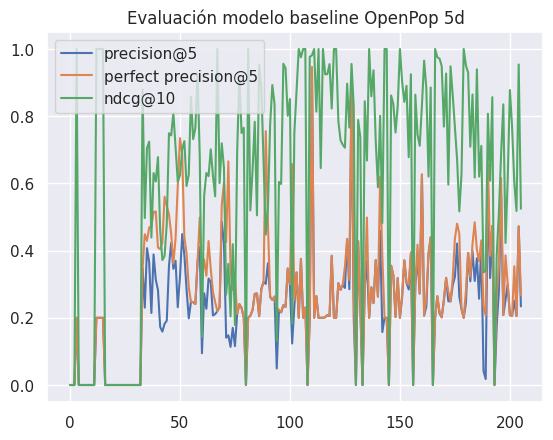

In [29]:
mdf = pd.DataFrame(metrics)
mdf['perfect precision@5'] = perfectmetrics['precision@5']
mdf['perfect precision@10'] = perfectmetrics['precision@10']
mdf['perfect map@10'] = perfectmetrics['map@10']
mdf[['precision@5', 'perfect precision@5', 'ndcg@10']].plot(title=f'Evaluación modelo baseline OpenPop {SPLITS_FREQ}')
mdf.describe()

In [30]:
mdf[-LAST_SPLITS:].describe()

,precision@5,ndcg@5,map@5,recall@5,precision@10,ndcg@10,map@10,recall@10,precision@15,ndcg@15,map@15,recall@15,perfect precision@5,perfect precision@10,perfect map@10
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.0
mean,0.290067,0.657316,0.569746,0.881358,0.155068,0.680170,0.585600,0.940249,0.103379,0.680170,0.585600,0.940249,0.322099,0.161748,1.0
std,0.125749,0.198625,0.235355,0.179618,0.061718,0.174301,0.219548,0.126851,0.041146,0.174301,0.219548,0.126851,0.137769,0.069538,0.0
min,0.205307,0.363612,0.268202,0.533375,0.102654,0.422600,0.317217,0.669501,0.068436,0.422600,0.317217,0.669501,0.205307,0.102654,1.0
25%,0.207923,0.498829,0.363481,0.778318,0.103961,0.543828,0.388274,1.000000,0.069308,0.543828,0.388274,1.000000,0.207923,0.103961,1.0
50%,0.242331,0.651870,0.562460,1.000000,0.142880,0.650261,0.563165,1.000000,0.095253,0.650261,0.563165,1.000000,0.283141,0.142880,1.0
75%,0.287957,0.818369,0.753935,1.000000,0.171862,0.818369,0.753935,1.000000,0.114575,0.818369,0.753935,1.000000,0.377726,0.189680,1.0
max,0.564506,0.953923,0.929610,1.000000,0.282253,0.953923,0.929610,1.000000,0.188169,0.953923,0.929610,1.000000,0.616329,0.311134,1.0


,t,model,variable,value
0,2020-09-20 21:21:16,openpop,precision@5,0.000000
1,2020-09-26 12:54:47,openpop,precision@5,0.000000
2,2020-10-01 13:28:02,openpop,precision@5,0.000000
3,2020-10-06 10:45:13,openpop,precision@5,0.200000
4,2020-10-11 18:59:02,openpop,precision@5,0.000000
...,...,...,...,...
819,2023-06-23 23:58:16,perfect,recall@5,1.000000
820,2023-06-28 23:59:50,perfect,recall@5,0.999226
821,2023-07-03 23:50:29,perfect,recall@5,1.000000
822,2023-07-08 23:47:19,perfect,recall@5,1.000000


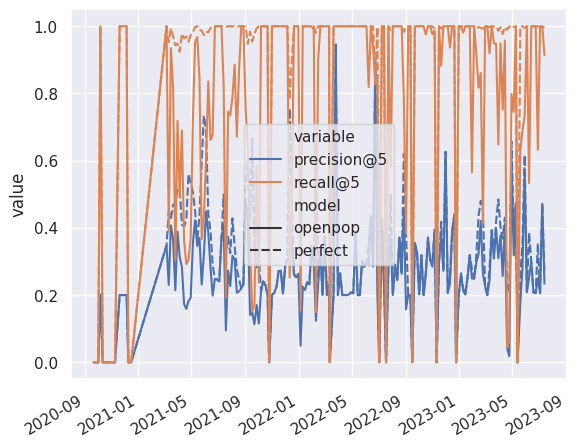

In [31]:
_METRICS = ['precision@5', 'recall@5']

_toplot = pd.concat([
    pd.DataFrame(metrics).assign(model='openpop'),
    pd.DataFrame(perfectmetrics).assign(model='perfect')
])
_toplot = _toplot[['t', 'model'] + _METRICS].melt(id_vars=['t', 'model'])
display(_toplot)

sns.lineplot(_toplot, x='t', y='value', hue='variable', style='model')
plt.xlabel("")
plt.xticks(rotation=30, ha='right');

,t,precision@5,ndcg@5,map@5,recall@5,precision@10,ndcg@10,map@10,recall@10,precision@15,ndcg@15,map@15,recall@15,model
0,2020-09-20 21:21:16,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,openpop
1,2020-09-26 12:54:47,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,openpop
2,2020-10-01 13:28:02,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,openpop
3,2020-10-06 10:45:13,0.200000,1.0,1.000000,1.000000,0.100000,1.0,1.0,1.0,0.066667,1.0,1.0,1.0,openpop
4,2020-10-11 18:59:02,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,openpop
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,2023-06-23 23:58:16,0.205811,1.0,1.000000,1.000000,0.102906,1.0,1.0,1.0,0.068604,1.0,1.0,1.0,perfect
202,2023-06-28 23:59:50,0.353417,1.0,0.999226,0.999226,0.177173,1.0,1.0,1.0,0.118115,1.0,1.0,1.0,perfect
203,2023-07-03 23:50:29,0.205307,1.0,1.000000,1.000000,0.102654,1.0,1.0,1.0,0.068436,1.0,1.0,1.0,perfect
204,2023-07-08 23:47:19,0.471915,1.0,1.000000,1.000000,0.235957,1.0,1.0,1.0,0.157305,1.0,1.0,1.0,perfect


Cannot show ipywidgets in text

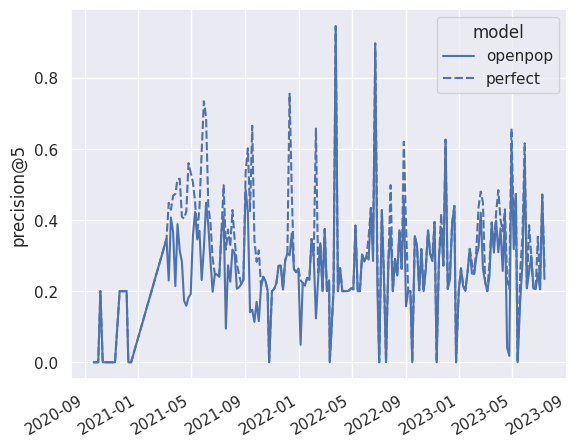

In [32]:
def _plot_metric(metric):
    _toplot = pd.concat([
        pd.DataFrame(metrics).assign(model='openpop'),
        pd.DataFrame(perfectmetrics).assign(model='perfect')
    ])

    display(_toplot)
    ax = sns.lineplot(_toplot, x='t', y=metric, style='model')
    plt.xlabel("")
    plt.xticks(rotation=30, ha='right');
    return ax

ax = _plot_metric('precision@5')
nbutils.download_matplotlib(ax.figure, f'10_all_precision@5_{SPLITS_FREQ}_{SPLITS_NORMALIZE}_{ORG_NAME}.pdf')

,t,precision@5,ndcg@5,map@5,recall@5,precision@10,ndcg@10,map@10,recall@10,precision@15,ndcg@15,map@15,recall@15,model
0,2020-09-20 21:21:16,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,openpop
1,2020-09-26 12:54:47,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,openpop
2,2020-10-01 13:28:02,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,openpop
3,2020-10-06 10:45:13,0.200000,1.0,1.000000,1.000000,0.100000,1.0,1.0,1.0,0.066667,1.0,1.0,1.0,openpop
4,2020-10-11 18:59:02,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,openpop
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,2023-06-23 23:58:16,0.205811,1.0,1.000000,1.000000,0.102906,1.0,1.0,1.0,0.068604,1.0,1.0,1.0,perfect
202,2023-06-28 23:59:50,0.353417,1.0,0.999226,0.999226,0.177173,1.0,1.0,1.0,0.118115,1.0,1.0,1.0,perfect
203,2023-07-03 23:50:29,0.205307,1.0,1.000000,1.000000,0.102654,1.0,1.0,1.0,0.068436,1.0,1.0,1.0,perfect
204,2023-07-08 23:47:19,0.471915,1.0,1.000000,1.000000,0.235957,1.0,1.0,1.0,0.157305,1.0,1.0,1.0,perfect


Cannot show ipywidgets in text

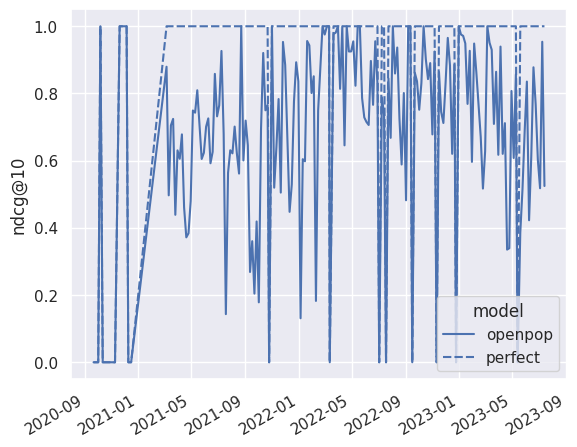

In [33]:
ax = _plot_metric('ndcg@10')
nbutils.download_matplotlib(ax.figure, f'10_all_ndcg@10_{SPLITS_FREQ}_{SPLITS_NORMALIZE}_{ORG_NAME}.pdf')

In [34]:
pmdf

,precision@5,ndcg@5,map@5,recall@5,precision@10,ndcg@10,map@10,recall@10,precision@15,ndcg@15,map@15,recall@15
0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
1,0.473488,1.0,0.936238,0.936238,0.290930,1.0,0.991893,0.991893,0.201240,1.0,0.999855,0.999855
2,0.240860,1.0,1.000000,1.000000,0.120430,1.0,1.000000,1.000000,0.080287,1.0,1.000000,1.000000
3,0.299319,1.0,0.998928,0.998928,0.150416,1.0,1.000000,1.000000,0.100278,1.0,1.000000,1.000000
4,0.263655,1.0,1.000000,1.000000,0.131828,1.0,1.000000,1.000000,0.087885,1.0,1.000000,1.000000
5,0.205589,1.0,1.000000,1.000000,0.102794,1.0,1.000000,1.000000,0.068530,1.0,1.000000,1.000000
6,0.428085,1.0,1.000000,1.000000,0.214043,1.0,1.000000,1.000000,0.142695,1.0,1.000000,1.000000
7,0.227027,1.0,1.000000,1.000000,0.113514,1.0,1.000000,1.000000,0.075676,1.0,1.000000,1.000000
8,0.306645,1.0,1.000000,1.000000,0.153322,1.0,1.000000,1.000000,0.102215,1.0,1.000000,1.000000
9,0.215515,1.0,1.000000,1.000000,0.107757,1.0,1.000000,1.000000,0.071838,1.0,1.000000,1.000000


,precision@5,ndcg@5,map@5,recall@5,precision@10,ndcg@10,map@10,recall@10,precision@15,ndcg@15,map@15,recall@15
count,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000
mean,0.280488,0.825243,0.818829,0.818829,0.145123,0.825243,0.824869,0.824869,0.097066,0.825243,0.825220,0.825220
std,0.183150,0.380684,0.378375,0.378375,0.100806,0.380684,0.380517,0.380517,0.067824,0.380684,0.380674,0.380674
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.200000,1.000000,0.977015,0.977015,0.100000,1.000000,0.999868,0.999868,0.066667,1.000000,1.000000,1.000000
50%,0.264419,1.000000,1.000000,1.000000,0.132209,1.000000,1.000000,1.000000,0.088140,1.000000,1.000000,1.000000
75%,0.385665,1.000000,1.000000,1.000000,0.195146,1.000000,1.000000,1.000000,0.130097,1.000000,1.000000,1.000000
max,0.945436,1.000000,1.000000,1.000000,0.556515,1.000000,1.000000,1.000000,0.383116,1.000000,1.000000,1.000000


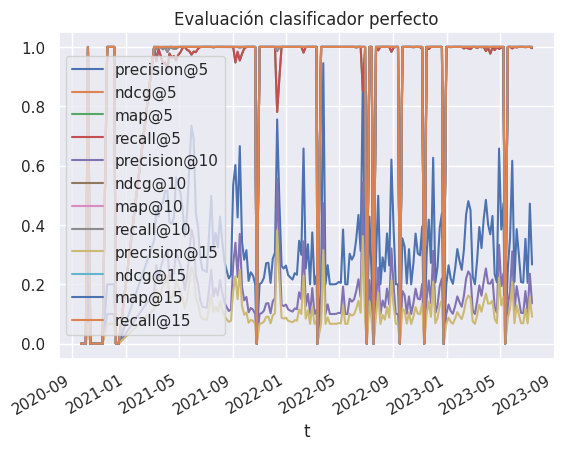

In [35]:
from src.baseline import write_metrics_perfect

pmdf = pd.DataFrame(perfectmetrics).set_index('t')

# pmdf.to_csv(paths.perfect_mp_freq(ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE))
write_metrics_perfect(pmdf, ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE)
pmdf.plot(title='Evaluación clasificador perfecto')
pmdf.describe()

## Exploring the folds

In [36]:
print(f"There are {len(folds)} folds")
print(f"From {df['timestamp'].min()} to {df['timestamp'].max()}")

full_len = len(df)
fold_len = []
for tr, ts, t, open_proposals in timeFreqSplitCurrent(df, SPLITS_FREQ, dfp, return_open=True, normalize=SPLITS_NORMALIZE):
    fold_len.append({
        't': t,
        'train': len(tr),
        'test': len(ts),
        'open': len(open_proposals),
        'test users': ts['userID'].nunique(),
        'test vpv': ts['userID'].nunique() / len(ts) if len(ts) else np.NaN,
        'test vpp': ts['userID'].nunique() / ts['itemID'].nunique() if len(ts) else np.NaN,
        # 't_train_min': tr['timestamp'].min(),
        # 't_train_max': tr['timestamp'].max(),
        't_test_min': ts['timestamp'].min(),
        't_test_max': ts['timestamp'].max(),
    })

fold_len = pd.DataFrame(fold_len)
fold_len.describe()

There are 206 folds
From 2020-09-17 18:50:14 to 2023-07-20 16:39:36


,train,test,open,test users,test vpv,test vpp
count,2.060000e+02,206.000000,206.000000,206.000000,180.000000,180.000000
mean,4.130610e+05,3226.936893,4.805825,1853.961165,0.687841,469.696370
std,6.060400e+05,6337.892026,4.331525,3272.491423,0.241171,716.301430
min,1.300000e+01,0.000000,0.000000,0.000000,0.175242,1.000000
25%,1.959675e+04,293.250000,1.000000,231.750000,0.477105,64.437500
50%,1.727130e+05,1228.000000,4.000000,688.000000,0.691349,225.050000
75%,4.347015e+05,3435.250000,7.000000,2059.000000,0.934026,550.625000
max,2.293735e+06,58249.000000,20.000000,17741.000000,1.000000,4439.666667


In [37]:
fold_len

,t,train,test,open,test users,test vpv,test vpp,t_test_min,t_test_max
0,2020-09-22,13,1,1,1,1.000000,1.000000,2020-09-23 11:35:41,2020-09-23 11:35:41
1,2020-09-27,18,8,1,8,1.000000,8.000000,2020-09-27 10:22:20,2020-09-30 11:13:05
2,2020-10-02,27,7,1,7,1.000000,7.000000,2020-10-03 07:40:21,2020-10-08 02:28:30
3,2020-10-07,54,57,2,56,0.982456,28.000000,2020-10-07 00:16:30,2020-10-31 15:39:50
4,2020-10-12,123,32,2,32,1.000000,32.000000,2020-10-13 08:06:30,2020-10-31 15:39:50
...,...,...,...,...,...,...,...,...,...
201,2023-06-24,2107798,1396,2,1360,0.974212,680.000000,2023-06-24 00:05:49,2023-07-02 18:56:31
202,2023-06-29,2113611,2872,6,1582,0.550836,263.666667,2023-06-29 00:01:37,2023-07-02 18:56:31
203,2023-07-04,2128083,13680,3,13319,0.973611,4439.666667,2023-07-04 00:08:37,2023-07-08 12:39:06
204,2023-07-09,2224945,1205,3,505,0.419087,168.333333,2023-07-09 00:05:38,2023-07-09 21:07:01


In [38]:
# Get folds with more than 10 open proposals
MIN_OPEN = 10 # obviously, to test @10, we need 10 open proposals
MIN_USERS = 5
MIN_VPP = 1

MIN_FOLDS = 10 + 1

# fold_len['min_open'] = (fold_len['open'] >= MIN_OPEN) & (fold_len['test users'] >= MIN_USERS)
fold_len['min'] = (fold_len['open'] >= MIN_OPEN)
print("There are", fold_len['min'].sum(), "folds that could be used")
fold_len['min_window'] = fold_len.rolling(MIN_FOLDS)['min'].sum() >= MIN_FOLDS
fold_len[fold_len['min_window']].tail(20)

There are 23 folds that could be used


,t,train,test,open,test users,test vpv,test vpp,t_test_min,t_test_max,min,min_window


In [39]:
fold_len['min2'] = fold_len['min'] & (fold_len['test vpp'] >= MIN_VPP)
print("There are", fold_len['min2'].sum(), "folds that could be used")
fold_len['min2_window'] = fold_len.rolling(MIN_FOLDS)['min2'].sum() >= MIN_FOLDS
fold_len[fold_len['min2_window']].tail(20)

There are 23 folds that could be used


,t,train,test,open,test users,test vpv,test vpp,t_test_min,t_test_max,min,min_window,min2,min2_window


            train  test  i
t                         
2020-09-22     13     1  0
2020-09-27     18     8  1
2020-10-02     27     7  2
2020-10-07     54    57  3
2020-10-12    123    32  4
2020-10-17    130    25  5
2020-10-22    143    12  6
2020-10-27    147     8  7
2020-11-01    155     0  8
2020-11-06    155     1  9


Cannot show ipywidgets in text

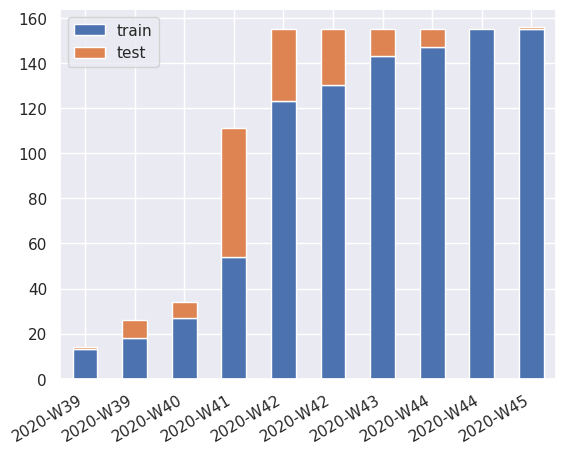

In [40]:
FIRST_FOLDS = 10
LAST_FOLDS = 0

# Bosquejo usando pandas.plot
_toplot = fold_len.set_index('t')[['train', 'test']]
_toplot['i'] = fold_len.index

_toplot = _toplot[ (_toplot['i'] < FIRST_FOLDS) | (_toplot['i'] > (len(_toplot) - LAST_FOLDS)) ]

print(_toplot)
ax = _toplot[['train', 'test']].plot.bar(stacked=True)
ax.set_xticks(np.arange(10), _toplot.index.strftime('%G-W%V'), rotation=30, ha='right')
ax.set_xlabel("")

nbutils.download_matplotlib(ax.figure, f'10_first_folds_{SPLITS_FREQ}_{SPLITS_NORMALIZE}_{ORG_NAME}.pdf')

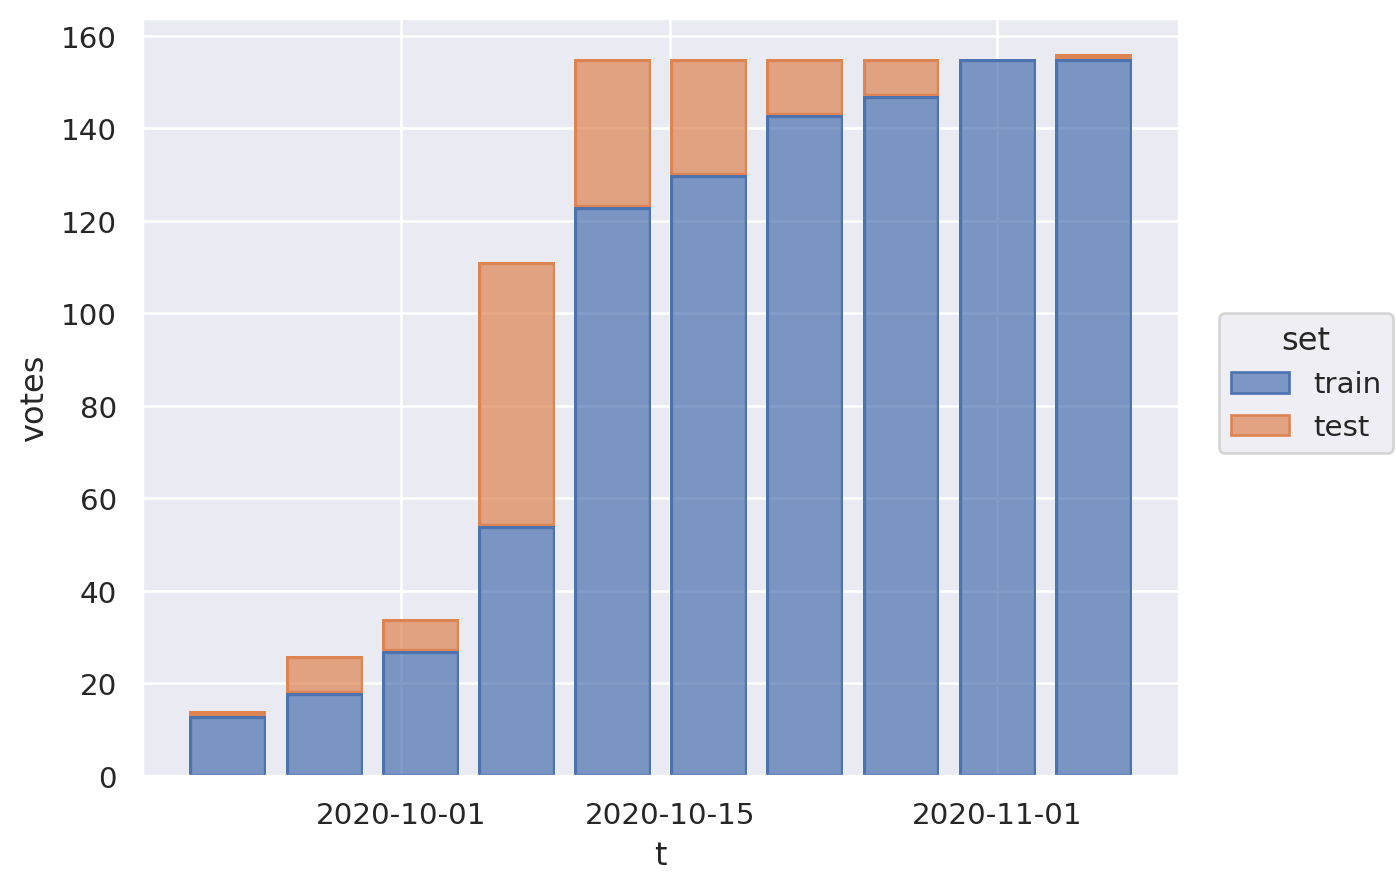

In [41]:
# Definitivo en seaborn
import seaborn.objects as so

_toplot = fold_len.assign(i=fold_len.index).melt(id_vars=['t', 'i'], value_vars=['train', 'test'], var_name='set', value_name='votes')
_toplot = _toplot[_toplot['i'] < FIRST_FOLDS]
so.Plot(_toplot, x='t', y='votes', color='set').add(so.Bar(), so.Stack())